In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from math import log2
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.pipeline import make_pipeline
import time
import matplotlib as mpl



from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,QuantileTransformer,normalize
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


import pathlib
import os
import sys

In [2]:
# Custom functions

module_path = pathlib.Path(os.getcwd()).parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))
print(sys.path)

from common.dataset_grabber import get_data_path

['/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2/Moneyball', '', '/home/alexander/ngsuite/ngsolve-install/lib/python3/dist-packages', '/home/alexander/ngsuite/ngsolve-install/bin', '/home/alexander/.local/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.358541065/pythonFiles', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.358541065/pythonFiles/lib/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/home/alexander/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/alexander/.local/lib/python3.7/site-packages/IPython/extensions', '/home/alexander/.ipython', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2']


In [5]:
datapath = get_data_path("Moneyball", "baseball.csv")
display(datapath)

PosixPath('/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2/Datasets/Moneyball/baseball.csv')

In [6]:
df_raw = pd.read_csv(datapath)

df_raw

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,PHI,NL,1962,705,759,81,0.330,0.390,0.260,0,NaN,NaN,161,NaN,NaN
1228,PIT,NL,1962,706,626,93,0.321,0.394,0.268,0,NaN,NaN,161,NaN,NaN
1229,SFG,NL,1962,878,690,103,0.341,0.441,0.278,1,1.0,2.0,165,NaN,NaN
1230,STL,NL,1962,774,664,84,0.335,0.394,0.271,0,NaN,NaN,163,NaN,NaN


# Data explenarision

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    244 non-null    float64
 11  RankPlayoffs  244 non-null    float64
 12  G             1232 non-null   int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 144.5+ KB


# Description of data columns

RS ... Runs Scored, 

RA ... Runs Allowed

***RD ... Run differential (actually difference)***

W ... Wins

OBP ... On-Base Percentage

SLG ... Slugging Percentage

BA ... Batting Average

Playoffs (binary)

RankSeason

RankPlayoffs

G ... Games Played

OOBP ... Opponent On-Base Percentage

OSLG ... Opponent Slugging Percentage

In [8]:
cols_to_drop = ['Team', 'League', 'Year', 'RankSeason', 'RankPlayoffs', 'Playoffs']
df_prep = df_raw.drop(cols_to_drop, axis=1)

# Fix missing values and type
df_prep.replace("?",0, inplace=True)
#df_prep = df_prep[df_prep.OOBP != 0]
df_prep[['OOBP','OSLG']] = df_prep[['OOBP','OSLG']].astype(float)

In [9]:
df_prep

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317,0.415
1,700,600,94,0.320,0.389,0.247,162,0.306,0.378
2,712,705,93,0.311,0.417,0.247,162,0.315,0.403
3,734,806,69,0.315,0.415,0.260,162,0.331,0.428
4,613,759,61,0.302,0.378,0.240,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...
1227,705,759,81,0.330,0.390,0.260,161,NaN,NaN
1228,706,626,93,0.321,0.394,0.268,161,NaN,NaN
1229,878,690,103,0.341,0.441,0.278,165,NaN,NaN
1230,774,664,84,0.335,0.394,0.271,163,NaN,NaN


# Handling missingvalues

420 Nan values are in the OOBP and OSLG column.

1) Stategie is to drop these rows with the Nan values. The impact of this stategie is that the dataset shrinks.

2) calculate the mean value from all other values in the column and replace it with it.

In [10]:
r_mean = np.mean(df_prep["OOBP"])
print(r_mean)
df_prep_mean = df_prep.replace(float('NaN'),r_mean)
r_mean = np.mean(df_prep["OSLG"])
print(r_mean)
df_prep_mean  = df_prep_mean.replace(float('NaN'),r_mean)

0.3322642857142857
0.41974285714285714


In [11]:
df_prep_mean

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317000,0.415000
1,700,600,94,0.320,0.389,0.247,162,0.306000,0.378000
2,712,705,93,0.311,0.417,0.247,162,0.315000,0.403000
3,734,806,69,0.315,0.415,0.260,162,0.331000,0.428000
4,613,759,61,0.302,0.378,0.240,162,0.335000,0.424000
...,...,...,...,...,...,...,...,...,...
1227,705,759,81,0.330,0.390,0.260,161,0.332264,0.332264
1228,706,626,93,0.321,0.394,0.268,161,0.332264,0.332264
1229,878,690,103,0.341,0.441,0.278,165,0.332264,0.332264
1230,774,664,84,0.335,0.394,0.271,163,0.332264,0.332264


In [12]:
df_prep_nomiss = df_prep.dropna()
df_prep_nomiss

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317,0.415
1,700,600,94,0.320,0.389,0.247,162,0.306,0.378
2,712,705,93,0.311,0.417,0.247,162,0.315,0.403
3,734,806,69,0.315,0.415,0.260,162,0.331,0.428
4,613,759,61,0.302,0.378,0.240,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...
415,872,831,86,0.356,0.434,0.271,162,0.345,0.423
416,809,838,75,0.338,0.426,0.262,161,0.355,0.427
417,772,913,69,0.343,0.411,0.274,162,0.371,0.448
418,945,859,95,0.361,0.479,0.293,162,0.346,0.459


# Distributions from the taget-clomum

In [13]:
np.mean(df_prep_nomiss["W"])

80.95714285714286

80.95714285714286


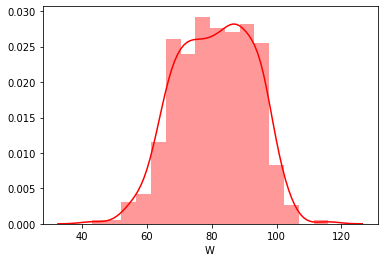

In [27]:
print(np.mean(df_prep_nomiss["W"]))
plot = sns.distplot(df_prep_nomiss["W"], color="red")
plt.savefig("out/explornation/nomiss.pdf")

80.90422077922078


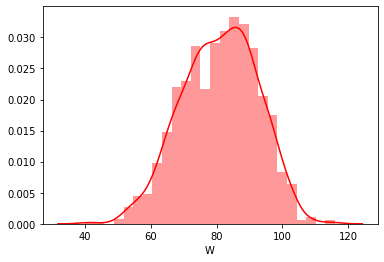

In [28]:
print(np.mean(df_prep_mean["W"]))
sns.distplot(df_prep_mean["W"], color="red")
plt.savefig("out/explornation/mean.pdf")